# Cell segmentation and detection

In this project, I investigated image segmentation and object detection using the data from the [Broad Bioimage Benchmark Collection](https://bbbc.broadinstitute.org/BBBC039). The dataset contains images of cells acquired using fluorescence microscopy, along with annotations of individual cells.

![A stack of images](./figs/broad_dataset.png)

## Imports

In [ ]:
# install packages
!pip install jupyter_black torchmetrics pycocotools -q

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import jupyter_black
import skimage
from tqdm.auto import tqdm

jupyter_black.load()

In [ ]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    ROOT_DIR = "/content/drive/MyDrive/CellProject"
except:
    ROOT_DIR = "."

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Understand Data

### Read files

In [ ]:
# get all the file names
all_file_names = pd.read_csv(
    f"{ROOT_DIR}/metadata/filenames_and_plates.csv", header=None
)
all_file_names = all_file_names[0].tolist()
all_file_names[:3]

['IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.png',
 'IXMtest_A06_s6_w1B9577918-4973-4A87-BA73-A168AA755527.png',
 'IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC717F32637.png']

In [ ]:
# get names of train, validation and test files
with open(f"{ROOT_DIR}/metadata/test.txt", "r") as f:
    test_file_names = f.read().splitlines()

with open(f"{ROOT_DIR}/metadata/training.txt", "r") as f:
    train_file_names = f.read().splitlines()

with open(f"{ROOT_DIR}/metadata/validation.txt", "r") as f:
    val_file_names = f.read().splitlines()

print(f"{len(train_file_names)} training images")
print(f"{len(val_file_names)} validation images")
print(f"{len(test_file_names)} test images")

100 training images
50 validation images
50 test images


In [ ]:
# get all file names from mask folder
mask_file_names = os.listdir(f"{ROOT_DIR}/masks")
mask_file_names[:3]

['IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC717F32637.png',
 'IXMtest_B04_s2_w17C6C7F8D-98F7-422B-92CD-EA61EE813325.png',
 'IXMtest_B21_s4_w1521471E0-9BD7-492A-8739-9C782C2585B0.png']

I won't include the following three images, because they had no information:
- IXMtest_F13_s7_w13C1B1D8C-293E-454F-B0FD-6C2C3F9F5173
- IXMtest_L10_s6_w12D12D64C-2639-4CA8-9BB4-99F92C9B7068
- IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC717F32637
- IXMtest_K18_s8_w11FC8D3EA-E30D-46B8-A45E-0399327AA8AC
- IXMtest_L01_s2_w1E5038251-DBA3-44D0-BC37-E43E2FC8C174

![A stack of images](./figs/special_train.png)

Load all images

In [ ]:
all_images = {
    "train_images": [],
    "val_images": [],
    "test_images": [],
    "train_masks": [],
    "val_masks": [],
    "test_masks": [],
}

bad_images = [
    "IXMtest_F13_s7_w13C1B1D8C-293E-454F-B0FD-6C2C3F9F5173",
    "IXMtest_L10_s6_w12D12D64C-2639-4CA8-9BB4-99F92C9B7068",
    "IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC717F32637",
    "IXMtest_K18_s8_w11FC8D3EA-E30D-46B8-A45E-0399327AA8AC",
    "IXMtest_L01_s2_w1E5038251-DBA3-44D0-BC37-E43E2FC8C174",
]

for file_name in tqdm(all_file_names):
    if file_name[:-4] in bad_images:
        continue
    image_name = file_name.split(".")[0] + ".tif"
    image = skimage.io.imread(f"{ROOT_DIR}/images/{image_name}")
    mask = skimage.io.imread(f"{ROOT_DIR}/masks/{file_name}")
    mask = mask[:, :, 0]

    if file_name in train_file_names:
        all_images["train_images"].append(image)
        all_images["train_masks"].append(mask)
    elif file_name in val_file_names:
        all_images["val_images"].append(image)
        all_images["val_masks"].append(mask)
    elif file_name in test_file_names:
        all_images["test_images"].append(image)
        all_images["test_masks"].append(mask)

# save all images and masks as numpy
for key in all_images.keys():
    all_images[key] = np.array(all_images[key])

  0%|          | 0/200 [00:00<?, ?it/s]

### Show an image with mask side by side

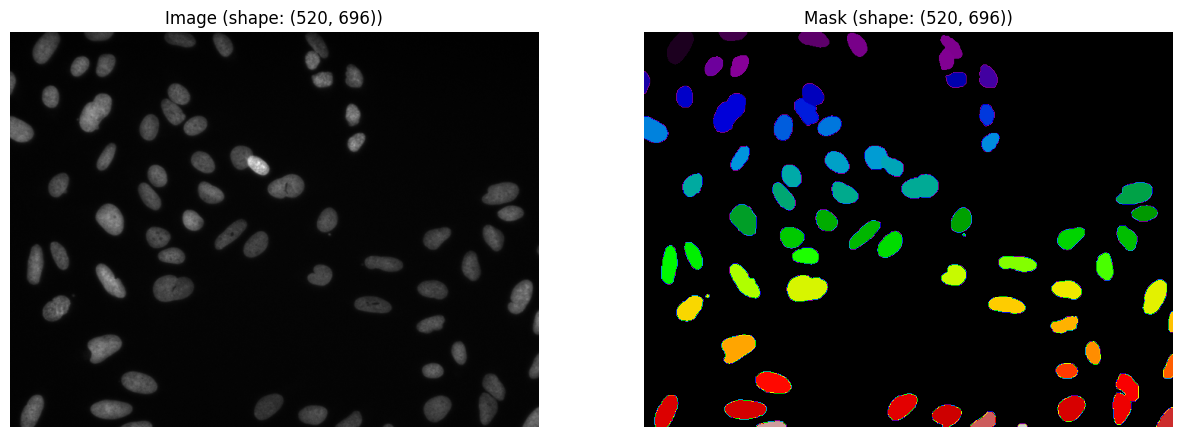

In [ ]:
file_idx = 0
mask_name = all_file_names[file_idx]
image_name = mask_name.split(".")[0] + ".tif"

# show image next to mask
image = all_images["train_images"][file_idx]
mask = all_images["train_masks"][file_idx]
mask = skimage.measure.label(mask)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(image, cmap="gray")
ax[0].axis("off")
ax[0].set_title(f"Image (shape: {image.shape})")

ax[1].imshow(mask, cmap="nipy_spectral")
ax[1].axis("off")
ax[1].set_title(f"Mask (shape: {mask.shape})")

plt.show()

## Create Datasets and Dataloaders

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
class UNetDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, mask = self.images[idx], self.masks[idx]

        # convert mask to binary
        mask = np.where(mask == 0, 0, 1)

        # convert to float32
        img = img.astype(np.float32)
        mask = mask.astype(np.float32)

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

In [ ]:
batch_size = 16

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

train_ds = UNetDataset(
    all_images["train_images"], all_images["train_masks"], transform=transform
)
val_ds = UNetDataset(
    all_images["val_images"], all_images["val_masks"], transform=transform
)
test_ds = UNetDataset(
    all_images["test_images"], all_images["test_masks"], transform=transform
)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

for images, masks in train_dl:
    print(f"images.shape: {images.shape}, masks.shape: {masks.shape}")
    break

images.shape: torch.Size([16, 1, 520, 696]), masks.shape: torch.Size([16, 1, 520, 696])


## U-Net Model

In [ ]:
from unet import UNet
from torchmetrics.classification import MulticlassJaccardIndex as iou

In [ ]:
def validate(model, val_loader, criterion, metric, device):
    model.eval()
    loss_step = []
    with torch.no_grad():
        for data in val_loader:
            inp_data, labels = data
            inp_data = inp_data.to(device)
            labels = labels.to(device)
            outputs = model(inp_data)
            val_loss = criterion(outputs, labels)
            iou_score = metric(outputs, labels).item()
            loss_step.append(val_loss.item())
        # dont forget to take the means here
        val_loss_epoch = torch.tensor(loss_step).mean().numpy()
        return iou_score, val_loss_epoch


def train_one_epoch(model, optimizer, train_loader, criterion, metric, device):
    model.train()
    loss_step = []
    for data in train_loader:
        # Move the data to the GPU
        inp_data, labels = data
        inp_data = inp_data.to(device)
        labels = labels.to(device)
        outputs = model(inp_data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_step.append(loss.item())
        with torch.no_grad():
            iou_score = metric(outputs, labels).item()
    # dont forget the means here
    loss_curr_epoch = np.mean(loss_step)
    return loss_curr_epoch, iou_score


def save_model(model, optimizer, epoch, dict_log, name):
    path = f"{ROOT_DIR}/models/{name}.pth"
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "dict_log": dict_log,
        },
        path,
    )


def load_model(model, optimizer, device, name):
    path = f"{ROOT_DIR}/models/{name}.pth"
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    dict_log = checkpoint["dict_log"]
    epoch = checkpoint["epoch"]
    return model, optimizer, epoch, dict_log


def train(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    metric,
    model_name,
    device,
    epochs,
):
    dict_log = {
        "train_loss": [],
        "val_loss": [],
        "train_iou": [],
        "val_iou": [],
    }
    pbar = tqdm(range(epochs), desc="Training")
    for epoch in pbar:
        loss_curr_epoch, train_iou = train_one_epoch(
            model, optimizer, train_loader, criterion, metric, device
        )
        val_iou, val_loss_epoch = validate(model, val_loader, criterion, metric, device)
        print(
            f"Epoch: {epoch+1}, Train Loss: {loss_curr_epoch:.4f}, Train IoU: {train_iou:.2f}, Val Loss: {val_loss_epoch:.4f}, Val IoU: {val_iou:.2f}"
        )

        dict_log["train_loss"].append(loss_curr_epoch)
        dict_log["val_loss"].append(val_loss_epoch)
        dict_log["train_iou"].append(train_iou)
        dict_log["val_iou"].append(val_iou)

    save_model(model, optimizer, epoch, dict_log, model_name)
    return dict_log

In [ ]:
criterion = torch.nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metric = iou(num_classes=2).to(device)
UNetModel = UNet(in_channels=1, out_channels=1, init_features=4).to(device)
optimizer = torch.optim.Adam(UNetModel.parameters(), lr=0.001)

print(f"Training on {device}")

Training on cuda


In [ ]:
train_model = False
epochs = 100

if train_model:
    dict_log = train(
        model=UNetModel,
        optimizer=optimizer,
        train_loader=train_dl,
        val_loader=val_dl,
        criterion=criterion,
        metric=metric,
        model_name=f"unet_model_{epochs}epochs",
        device=device,
        epochs=100,
    )
else:
    UNetModel, optimizer, epoch, dict_log = load_model(
        UNetModel, optimizer, device, f"unet_model_{epochs}epochs"
    )
    print(f"Loaded U-Net at epoch {epoch}")

Loaded U-Net at epoch 99


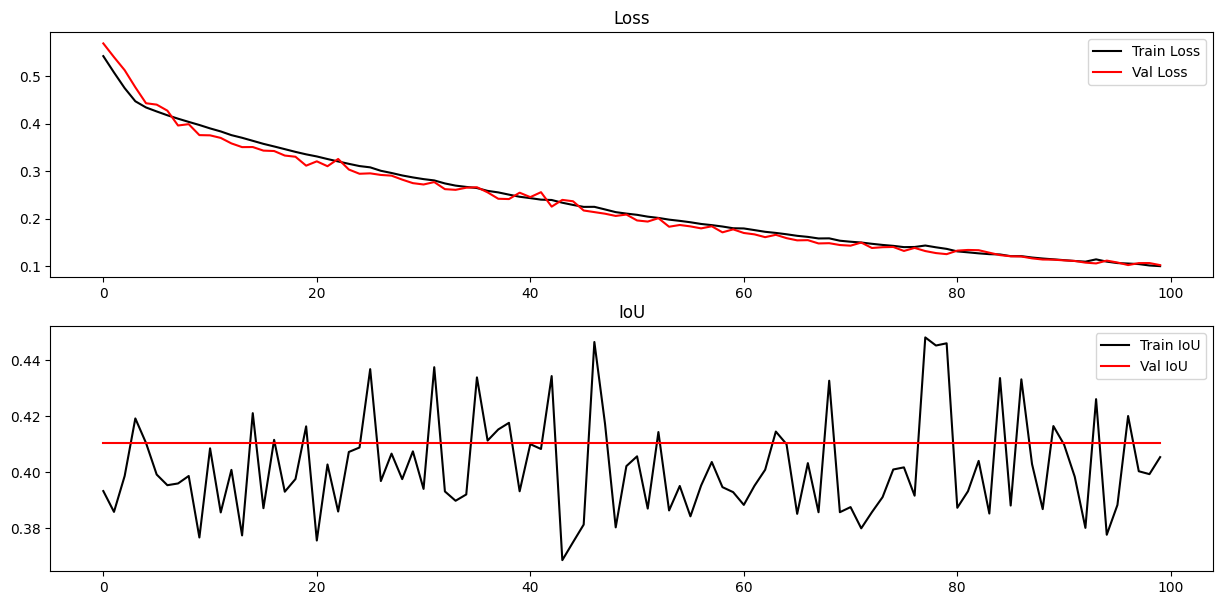

In [ ]:
def show_dict_log(dict_log):
    fig, ax = plt.subplots(2, 1, figsize=(15, 7))
    ax[0].plot(dict_log["train_loss"], label="Train Loss", c="k")
    ax[0].plot(dict_log["val_loss"], label="Val Loss", c="r")
    ax[0].set_title("Loss")
    ax[0].legend()

    ax[1].plot(dict_log["train_iou"], label="Train IoU", c="k")
    ax[1].plot(dict_log["val_iou"], label="Val IoU", c="r")
    ax[1].set_title("IoU")
    ax[1].legend()

    plt.show()


show_dict_log(dict_log)

In [ ]:
# predict on test set
UNetModel.eval()
test_iou, test_loss = validate(UNetModel, test_dl, criterion, metric, device)

print(f"Test IoU: {test_iou:.2f}, Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Test IoU: 0.45, Test Loss: 0.0983


In [ ]:
test_preds = []
for data in test_dl:
    inp_data, labels = data
    inp_data = inp_data.to(device)
    labels = labels.to(device)
    outputs = UNetModel(inp_data)
    outputs = outputs.cpu().detach().numpy()
    outputs = np.where(outputs > 0.3, 1, 0)
    test_preds.append(outputs)
    break

test_preds = np.concatenate(test_preds)

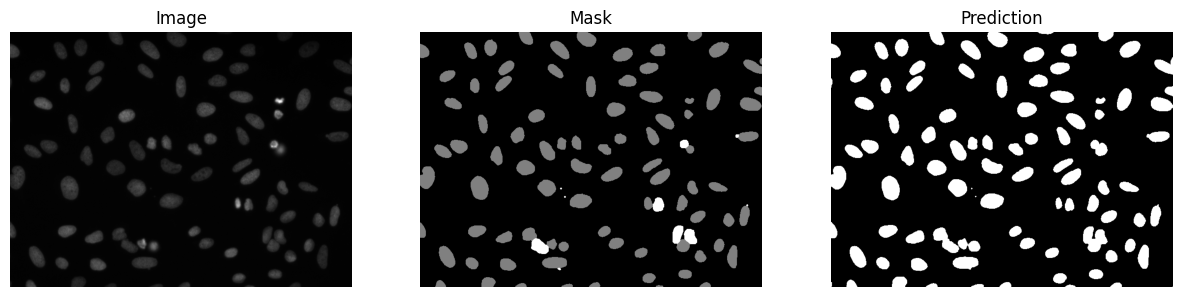

In [ ]:
# visualize image next mask next prediction
file_idx = 2
image = all_images["test_images"][file_idx]
mask = all_images["test_masks"][file_idx]
pred = test_preds[file_idx][0]

fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(image, cmap="gray")
ax[0].axis("off")
ax[0].set_title(f"Image")

ax[1].imshow(mask, cmap="gray")
ax[1].axis("off")
ax[1].set_title(f"Mask")

ax[2].imshow(pred, cmap="gray")
ax[2].axis("off")
ax[2].set_title(f"Prediction")

plt.show()

## Object Detection

In [ ]:
# load files
os.system(
    "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py"
)
os.system(
    "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py"
)
os.system(
    "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py"
)
os.system(
    "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py"
)
os.system(
    "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py"
)
print("loaded files")

loaded files


#### Create Dataset for object detection

In [ ]:
class DetectionDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.images[idx]
        mask = self.masks[idx]

        # normalize
        image = image - np.mean(image, axis=0) / np.std(image, axis=0)

        # Process the mask
        labeled_mask = skimage.measure.label(mask)
        props = skimage.measure.regionprops(labeled_mask)
        bboxes = []
        for prop in props:
            y1, x1, y2, x2 = prop.bbox
            bboxes.append([x1, y1, x2, y2])

        num_classes = labeled_mask.max()
        assert num_classes == len(
            bboxes
        ), "Number of classes and number of bboxes do not match"
        labeled_mask = torch.tensor(labeled_mask, dtype=torch.int64)
        obj_ids = torch.unique(labeled_mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        final_mask = labeled_mask == obj_ids[:, None, None]

        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        final_mask = final_mask.clone().detach().to(torch.uint8)
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.ones((num_classes,), dtype=torch.int64)

        if len(bboxes.shape) == 2 and bboxes.shape[-1] == 4:
            area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        else:
            print(num_classes, bboxes.shape, idx)
            bboxes = torch.zeros((num_classes, 4), dtype=torch.float32)
            area = torch.zeros((num_classes, 4), dtype=torch.float32)

        iscrowd = torch.zeros((num_classes,), dtype=torch.int64)

        target = {
            "boxes": bboxes,
            "labels": labels,
            "masks": final_mask,
            "image_id": idx,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transform:
            image = self.transform(image)

        return image, target

In [ ]:
import utils

###############################################
batch_size = 8
###############################################

train_ds = DetectionDataset(
    images=all_images["train_images"],
    masks=all_images["train_masks"],
)
val_ds = DetectionDataset(
    images=all_images["val_images"],
    masks=all_images["val_masks"],
)
test_ds = DetectionDataset(
    images=all_images["test_images"], masks=all_images["test_masks"]
)

train_dl = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, collate_fn=utils.collate_fn
)
val_dl = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, collate_fn=utils.collate_fn
)
test_dl = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, collate_fn=utils.collate_fn
)

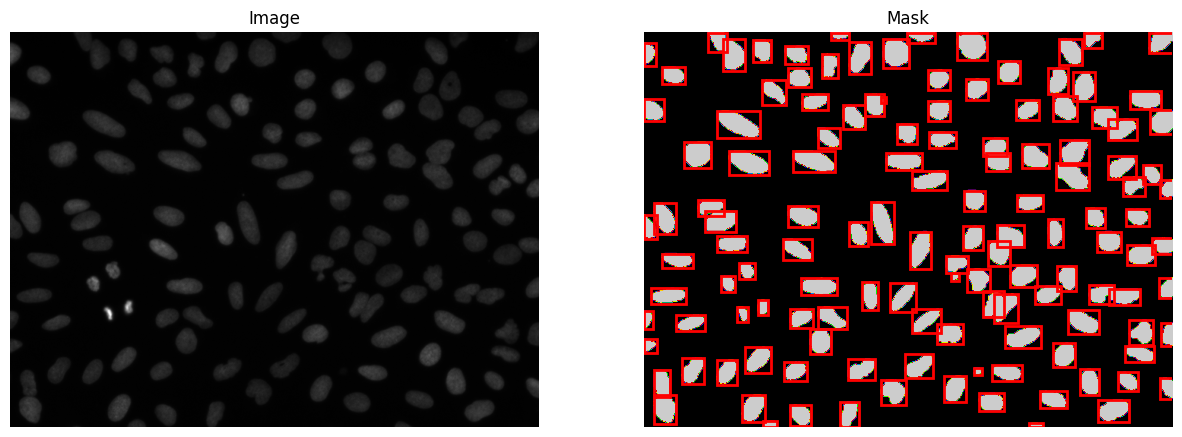

In [ ]:
# visualize image next to mask with bounding boxes
batch = next(iter(train_dl))
image, target = batch

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(image[0].permute(1, 2, 0), cmap="gray")
ax[0].axis("off")
ax[0].set_title(f"Image")

mask = target[0]["masks"].numpy()
mask = np.sum(mask, axis=0)
ax[1].imshow(mask, cmap="nipy_spectral")
ax[1].axis("off")
ax[1].set_title(f"Mask")

for bbox in target[0]["boxes"]:
    x1, y1, x2, y2 = bbox
    rect = plt.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="r", linewidth=2
    )
    ax[1].add_patch(rect)

plt.show()

#### Mask R-CNN

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
MaskRCNN = maskrcnn_resnet50_fpn(weights="DEFAULT")
in_features = MaskRCNN.roi_heads.box_predictor.cls_score.in_features
MaskRCNN.roi_heads.box_predictor = FastRCNNPredictor(
    in_features, num_classes=2
)  # we have 2 classes
MaskRCNN.to(device)
print(f"Loaded maskrcnn_resnet50_fpn")

Loaded maskrcnn_resnet50_fpn


In [ ]:
from engine import train_one_epoch, evaluate


def train_MaskRCNN(
    model, optimizer, train_loader, val_loader, device, epochs, print_every=1
):
    model.train()
    dict_log = {
        "train_loss": [],
        "val_loss": [],
    }

    for epoch in range(epochs):
        train_loss = train_one_epoch(
            model, optimizer, train_loader, device, epoch, print_freq=print_every
        )
        dict_log["train_loss"].append(train_loss)

        evaluate(model, val_loader, device)

        if epoch > 20 and (epoch%10==0):
            save_model(model, optimizer, epoch, dict_log, f"maskrcnn_model_{epoch}epochs_mid_DEFAULTweights")

    save_model(model, optimizer, epoch, dict_log, f"maskrcnn_model_{epochs}epochs_final_DEFAULTweights")

    return dict_log

In [ ]:
optimizer = torch.optim.Adam(MaskRCNN.parameters(), lr=1e-5)

train_maskrcnn = False
epochs = 50

if train_maskrcnn:
    dict_log = train_MaskRCNN(
        model=MaskRCNN,
        optimizer=optimizer,
        train_loader=train_dl,
        val_loader=val_dl,
        device=device,
        epochs=epochs,
    )
else:
    MaskRCNN, optimizer, epoch, dict_log = load_model(
        MaskRCNN, optimizer, device, f"maskrcnn_model_{epochs}epochs"
    )
    print(f"Loaded MaskRCNN at epoch {epoch}")

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: [0]  [ 0/13]  eta: 0:00:47  lr: 0.000001  loss: 1301.4863 (1301.4863)  loss_classifier: 15.9725 (15.9725)  loss_box_reg: 262.5157 (262.5157)  loss_mask: 421.2805 (421.2805)  loss_objectness: 469.8181 (469.8181)  loss_rpn_box_reg: 131.8996 (131.8996)  time: 3.6819  data: 0.9213  max mem: 10419
Epoch: [0]  [ 1/13]  eta: 0:00:45  lr: 0.000002  loss: 1223.7410 (1262.6136)  loss_classifier: 15.9725 (17.0364)  loss_box_reg: 262.5157 (272.5885)  loss_mask: 417.8804 (419.5804)  loss_objectness: 370.0374 (419.9277)  loss_rpn_box_reg: 131.8996 (133.4806)  time: 3.8122  data: 1.1571  max mem: 11090
Epoch: [0]  [ 2/13]  eta: 0:00:42  lr: 0.000003  loss: 1301.4863 (1305.9261)  loss_classifier: 18.1003 (17.7422)  loss_box_reg: 282.6613 (289.5100)  loss_mask: 421.2805 (438.0113)  loss_objectness: 430.1631 (423.3395)  loss_rpn_box_reg: 135.0615 (137.3231)  time: 3.8227  data: 1.2294  max mem: 11090
Epoch: [0]  [ 3/13]  eta: 0:00:37  lr: 0.000003  loss: 1301.4863 (1341.8841)  loss_classifier: 17

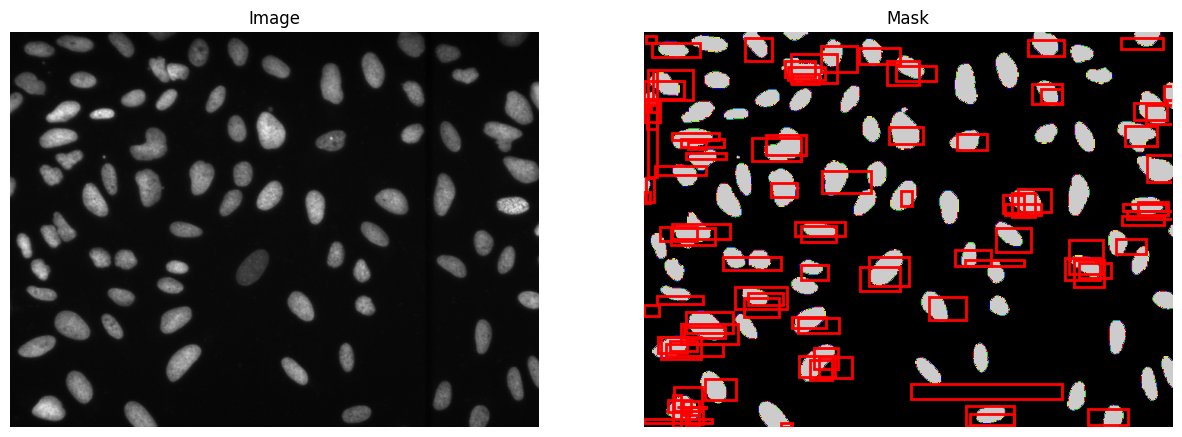

In [ ]:
MaskRCNN.eval()

# test prediction
for images, targets in test_dl:
    images = list(image.to(device) for image in images)
    # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    outputs = MaskRCNN(images)
    break

# visualize image next to mask with bounding boxes
idx = 1
image = images[idx].cpu().numpy().squeeze()
mask = targets[idx]["masks"].cpu().numpy()
mask = np.sum(mask, axis=0)
pred = outputs[idx]

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(image, cmap="gray")
ax[0].axis("off")
ax[0].set_title(f"Image")

ax[1].imshow(mask, cmap="nipy_spectral")
ax[1].axis("off")
ax[1].set_title(f"Mask")

for bbox in pred["boxes"]:
    x1, y1, x2, y2 = bbox.cpu().detach().numpy()
    rect = plt.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="r", linewidth=2
    )
    ax[1].add_patch(rect)

plt.show()

# Limitation

The final result demonstrates clear evidence that the model has learned to detect the cells and utilise different shaped boxes. However, due to the limitations of the available compute resources, it was not possible to continue training the model and further enhance the result.